<a href="https://colab.research.google.com/github/fatwaman/Learning_Python/blob/main/Capstone_Project_Fatwa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CAPSTONE PROJECT FATWA RAFIUDIN**

## **1. LOAD LIBRARIES AND DATASET**

### 1.1. Import Necessary Libraries and Dataset

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re #regex

# Import dataset which still in sql file (MySQL)
from google.colab import files
upload = files.upload()
file_path = 'datatransaksi.sql'

Saving datatransaksi.sql to datatransaksi.sql


### 1.2 Convert Dataset to JSON format

In [2]:
def parse_mysql_insert(file_path):
    """
    Parses a MySQL .sql file, extracts data from INSERT statements, and returns a list of dictionaries.
    """
    data = []
    # Regex to find the values inside the `values(...)` part of an INSERT statement
    pattern = re.compile(r"values\((.*?)\);")

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            # Check for INSERT statements
            if line.startswith("insert into `laporan`"):
                match = pattern.search(line)
                if match:
                    values_string = match.group(1)
                    # Split the string by single quotes and commas to get individual values
                    # The regex splits by a comma followed by a single quote, which is more robust
                    # than a simple comma split for cases where values might contain commas.
                    values = re.findall(r"'([^']*)'", values_string)

                    # Convert values to the correct data types based on the table schema
                    # id: int, id_user: int, tanggal: varchar, jumlah_transaksi: int, jumlah_total: float
                    record = {
                        "id": int(values[0]),
                        "id_user": int(values[1]),
                        "tanggal": values[2],
                        "jumlah_transaksi": int(values[3]),
                        "jumlah_total": float(values[4])
                    }
                    data.append(record)
    return data

# Replace 'datatransaksi.sql' with the actual path to your file
parsed_data = parse_mysql_insert(file_path)

# Print the parsed data
import json
print(json.dumps(parsed_data[:5], indent=4)) # Print Top 5 JSON Result


[
    {
        "id": 5,
        "id_user": 51,
        "tanggal": "2017-03-02",
        "jumlah_transaksi": 0,
        "jumlah_total": 0.0
    },
    {
        "id": 6,
        "id_user": 51,
        "tanggal": "2017-03-01",
        "jumlah_transaksi": 0,
        "jumlah_total": 0.0
    },
    {
        "id": 11,
        "id_user": 51,
        "tanggal": "2017-03-06",
        "jumlah_transaksi": 0,
        "jumlah_total": 0.0
    },
    {
        "id": 15,
        "id_user": 2854,
        "tanggal": "2017-03-07",
        "jumlah_transaksi": 1,
        "jumlah_total": 100000.0
    },
    {
        "id": 18,
        "id_user": 51,
        "tanggal": "2017-03-07",
        "jumlah_transaksi": 0,
        "jumlah_total": 0.0
    }
]


### 1.3 Convert JSON Parsing to Pandas Dataframe

In [3]:
# Converts it into a pandas DataFrame. Table-like structure similar to a spreadsheet or a table in a database
df = pd.DataFrame(parsed_data)
df.head()

,id,id_user,tanggal,jumlah_transaksi,jumlah_total
0,5,51,2017-03-02,0,0.0
1,6,51,2017-03-01,0,0.0
2,11,51,2017-03-06,0,0.0
3,15,2854,2017-03-07,1,100000.0
4,18,51,2017-03-07,0,0.0


## **2. DATA CLEANING**

### 2.1 Rename Column and Check Important Column

In [6]:
# Column standardization and date parsing

# Read as a string so that date parsing can be controlled
df = pd.DataFrame(parsed_data)

# Rename column name to english version
rename_map = {
    'tanggal': 'date',
    'jumlah_transaksi': 'number of transactions',
    'jumlah_total': 'total_amount'
}
df.rename(columns = rename_map, inplace = True)
#df = df.rename(columns={c:e for c,e in rename_map.items() if c in df.columns})

# Check important columns and raise error if found
required = {'id_user', 'date', 'total_amount'}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Required column is missing: {missing}. Please check your sql file.")

### 2.2 Tidy Up Column Name

In [7]:
# Tidy up column name (trim the name and make all lowercase)
df.columns = df.columns.str.strip().str.lower()

# Check id_user columnn and convert to string
df['id_user'] = df['id_user'].astype(str).str.strip()

# Check total_amount columnn and convert to numeric
df['total_amount'] = pd.to_numeric(df['total_amount'], errors='coerce')

### 2.3 Date Cleaning and Standardization

In [8]:
# Parsing date ensures all its values are treated as strings and trim the value
s = df['date'].astype(str).str.strip()

# Change date separator from "." or "/" to "-"
s = s.str.replace(r'[./]', '-', regex=True)

# Check common date pattern
mask_ymd   = s.str.match(r'^\d{4}-\d{1,2}-\d{1,2}$')   # YYYY-MM-DD
mask_dmy   = s.str.match(r'^\d{1,2}-\d{1,2}-\d{4}$')   # DD-MM-YYYY
mask_8dig  = s.str.match(r'^\d{8}$')                   # YYYYMMDD

date_nya = pd.Series(pd.NaT, index=s.index, dtype='datetime64[ns]')
date_nya[mask_ymd]  = pd.to_datetime(s[mask_ymd],  format='%Y-%m-%d', errors='coerce')
date_nya[mask_dmy]  = pd.to_datetime(s[mask_dmy],  format='%d-%m-%Y', errors='coerce')
date_nya[mask_8dig] = pd.to_datetime(s[mask_8dig], format='%Y%m%d',   errors='coerce')
rest = ~(mask_ymd | mask_dmy | mask_8dig)
date_nya[rest] = pd.to_datetime(s[rest], errors='coerce', dayfirst=True)

df['date'] = date_nya

df.head()

,id,id_user,date,number of transactions,total_amount
0,5,51,2017-03-02,0,0.0
1,6,51,2017-03-01,0,0.0
2,11,51,2017-03-06,0,0.0
3,15,2854,2017-03-07,1,100000.0
4,18,51,2017-03-07,0,0.0


## **3. IMPLEMENT LARGE LANGUAGE MODEL (LLM)**

### 3.1 Install LLM from Replicate (replicate.com)

In [9]:
# Install llm
!pip install replicate
!pip install langchain_community

### 3.2 Set Up API Token and Model Environment

In [10]:
from langchain_community.llms import Replicate
from google.colab import userdata
import os

# Set the API token
api_token = userdata.get("api_token")
os.environ['REPLICATE_API_TOKEN'] = api_token

# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
llm = Replicate(
    model=model,
    replicate_api_token=api_token,
)

### 3.3 Give Order to LLM and Try the Result

In [11]:
output = llm.invoke("in what date which have highest total_amount and what is the value? please make python script")
print(output)

To solve this problem, we'll assume you have a pandas DataFrame named `df` with a column named `total_amount` and a column named `date`. The script will find the date with the highest `total_amount` and print both the date and the value.

Here's the Python script using pandas:

```python
import pandas as pd

# Assuming df is your DataFrame and it has columns 'date' and 'total_amount'
max_amount_date = df['date'][df['total_amount'].idxmax()]
max_amount = df['total_amount'].max()

print(f"The date with the highest total_amount is {max_amount_date} and the value is {max_amount}.")
```

This script first finds the index of the maximum value in the `total_amount` column using `idxmax()`. It then uses this index to extract the corresponding date from the `date` column. Finally, it prints the date and the maximum value.

Make sure you have the pandas library installed. If not, you can install it using:

```bash
pip install pandas
```

Replace `df` with your actual DataFrame name in the script

In [20]:
# Group by 'date' and sum 'total_amount'
grouped = df.groupby('date')['total_amount'].sum().reset_index()

# Find the date with the maximum total_amount
max_amount_date = grouped.loc[grouped['total_amount'].idxmax()]
max_amount_value = grouped['total_amount'].max()

print(f"The date with the highest total_amount is {max_amount_date['date']} and the value is {max_amount_value}.")

The date with the highest total_amount is 2018-06-10 00:00:00 and the value is 101087209796.2.


In [21]:
output = llm.invoke(f"I want to see datatransaksi in bar chart for total_amount per year, please make python script")
print(output)

To create a bar chart for the total_amount per year from a dataset named `datatransaksi`, you can use the libraries `pandas` for data manipulation and `matplotlib` for visualization. Here's a Python script that assumes your data is in a CSV file with columns 'tanggal' (date) and 'total_amount'.

```python
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
# Assuming your CSV file is named 'datatransaksi.csv' and has columns 'tanggal' (date) and 'total_amount'
datatransaksi = pd.read_csv('datatransaksi.csv')

# Convert 'tanggal' column to datetime if it isn't already
datatransaksi['tanggal'] = pd.to_datetime(datatransaksi['tanggal'])

# Extract the year from the 'tanggal' column
datatransaksi['year'] = datatransaksi['tanggal'].dt.year

# Group the data by year and sum the 'total_amount'
yearly_total = datatransaksi.groupby('year')['total_amount'].sum().reset_index()

# Plot the data as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(yearly

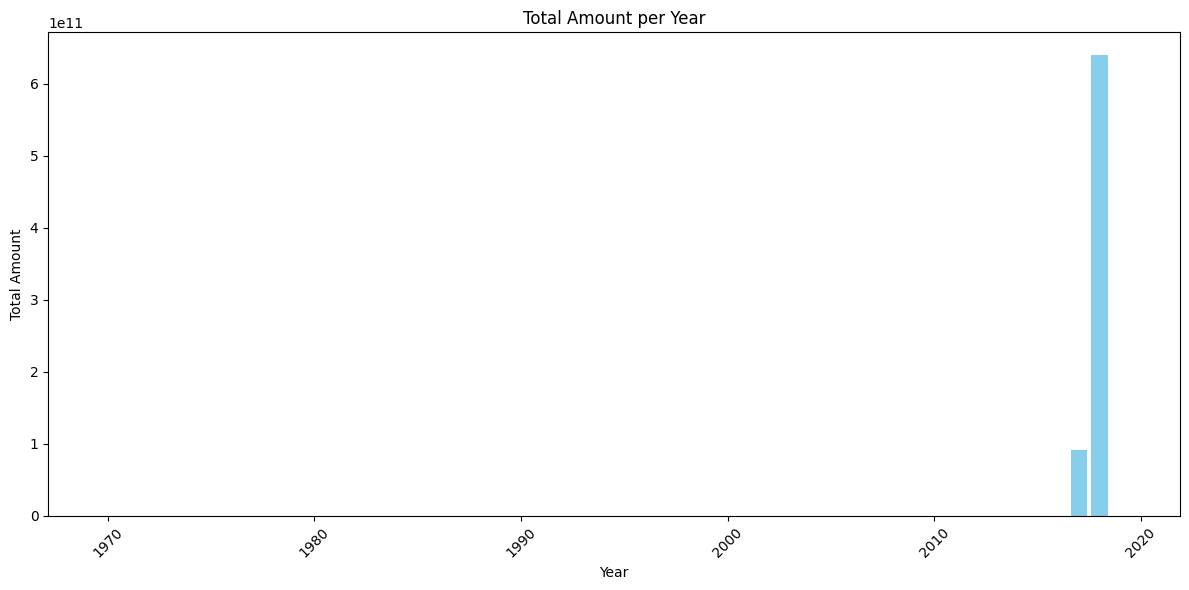

    year  total_amount
0   1970  8.020000e+05
1   2000  2.950000e+05
2   2009  8.000000e+03
3   2010  6.652000e+06
4   2012  2.760000e+05
5   2013  7.028500e+06
6   2014  1.400000e+04
7   2015  2.016050e+07
8   2016  3.852400e+07
9   2017  9.090494e+10
10  2018  6.391671e+11
11  2019  1.051000e+06


In [25]:
# Load your data
# Assuming your CSV file is named 'datatransaksi.csv' and has columns 'tanggal' (date) and 'total_amount'
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'tanggal' column
df['year'] = df['date'].dt.year

# Group the data by year and sum the 'total_amount'
yearly_total = df.groupby('year')['total_amount'].sum().reset_index()

# Plot the data as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(yearly_total['year'], yearly_total['total_amount'], color='skyblue')

# Add title and labels
plt.title('Total Amount per Year')
plt.xlabel('Year')
plt.ylabel('Total Amount')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

print(yearly_total)

In [27]:
output = llm.invoke("conduct a monthly cohort analysis to determine how long users retain the transaction feature. Ensure that only transactions with total_transactions > 0 are counted. Please make python script")
print(output)

To conduct a monthly cohort analysis in Python, you can use the pandas library to manipulate and analyze your transaction data. Below is a Python script that performs the cohort analysis, focusing on users who have made at least one transaction (`total_transactions > 0`). The script calculates the retention rate for each cohort (group of users who joined in the same month) over a specified period.

```python
import pandas as pd
from datetime import datetime

# Sample transaction data
# Replace this with your actual transaction data
data = {
    'user_id': [1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
    'transaction_date': [
        '2023-01-15', '2023-02-20', '2023-01-25', '2023-02-10', 
        '2023-02-01', '2023-03-05', '2023-02-28', '2023-03-12', 
        '2023-03-03', '2023-04-07'
    ],
    'total_transactions': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
}

# Convert transaction_date to datetime
df = pd.DataFrame(data)
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Define the retenti

## **4. COHORT PREPARATION**

### 3.1 Filter Data

In [28]:
# Filter valid data which are not NaT (Not a Time) or NoN (Not a Number) and total_amount > 0
df = df.dropna(subset=['date', 'id_user', 'total_amount']) # Filter exclude NaT or NaN data
df = df[df['total_amount'] > 0] # Filter total_amount > 0

# Check if found years anomaly, in this data are take out < 2010
yrs = df['date'].dt.year
print("Date range is from:", df['date'].min(), "→", df['date'].max())
print("Number of rows which have year < 2010:", int((yrs < 2010).sum()), "row(s)")

Date range is from: 1970-01-01 00:00:00 → 2019-12-25 00:00:00
Number of rows which have year < 2010: 4 row(s)


In [29]:
df = df[df['date'].dt.year >= 2015].reset_index(drop=True) # Resets the index to a clean sequence starting from 0
df[ df['date'].dt.year < 2015 ].head(10) # Quick check to see if any data from before the year 2000 still exists in the DataFrame after the filtering step

,id,id_user,date,number of transactions,total_amount,year


### 3.2 Define Transaction Month and Cohort Month

In [30]:
# For transaction month and Cohort month, and aging
# Bulan transaksi & bulan cohort (gunakan Period → aman)
df['transaction_month']  = df['date'].dt.to_period('M').dt.to_timestamp()

first_tx = (df.groupby('id_user', as_index=False)['transaction_month']
              .min()
              .rename(columns={'transaction_month':'cohort_month'}))

df = df.merge(first_tx, on='id_user', how='left')

def month_diff(d1, d2):
    return (d1.dt.year - d2.dt.year) * 12 + (d1.dt.month - d2.dt.month)

df['cohort_index'] = month_diff(df['transaction_month'], df['cohort_month']) + 1
df.head()

,id,id_user,date,number of transactions,total_amount,year,transaction_month,cohort_month,cohort_index
0,15,2854,2017-03-07,1,100000.0,2017,2017-03-01,2017-03-01,1
1,19,2874,2017-03-07,2,181000.0,2017,2017-03-01,2017-03-01,1
2,25,2887,2017-03-08,1,3000.0,2017,2017-03-01,2017-03-01,1
3,26,2939,2017-03-08,1,103000.0,2017,2017-03-01,2017-03-01,1
4,39,2926,2017-03-10,1,50000.0,2017,2017-03-01,2017-03-01,1


### 3.3 Matrix Retention Calculation and Active User

In [31]:
# Calculate Retension Matrix (Percentage)
# Active user per (cohort_month x cohort_index)
cohort_counts = (
    df.groupby(['cohort_month', 'cohort_index'])['id_user']
      .nunique()
      .reset_index(name='active_users')
)

# Cohort size = user on first month
cohort_sizes = (
    cohort_counts[cohort_counts['cohort_index'] == 1]
    .rename(columns={'active_users':'cohort_size'})[['cohort_month','cohort_size']]
)

cohort_counts = cohort_counts.merge(cohort_sizes, on='cohort_month', how='left')
cohort_counts['retention'] = cohort_counts['active_users'] / cohort_counts['cohort_size']

# Pivot → persen
retention_pct = (cohort_counts.pivot_table(
    index='cohort_month', columns='cohort_index',
    values='retention', aggfunc='mean'
).fillna(0) * 100).round(1)

retention_pct.index = retention_pct.index.strftime('%Y-%m')  # rapi
retention_pct.head()


cohort_index,1,2,3,4,5,6,7,8,9,10,...,34,35,36,37,38,40,41,42,43,44
cohort_month,,,,,,,,,,,,,,,,,,,,,
2015-01,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.3,33.3,16.7,33.3,16.7,16.7,50.0,33.3,33.3,33.3
2015-07,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-09,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.4 Cohort Visualization

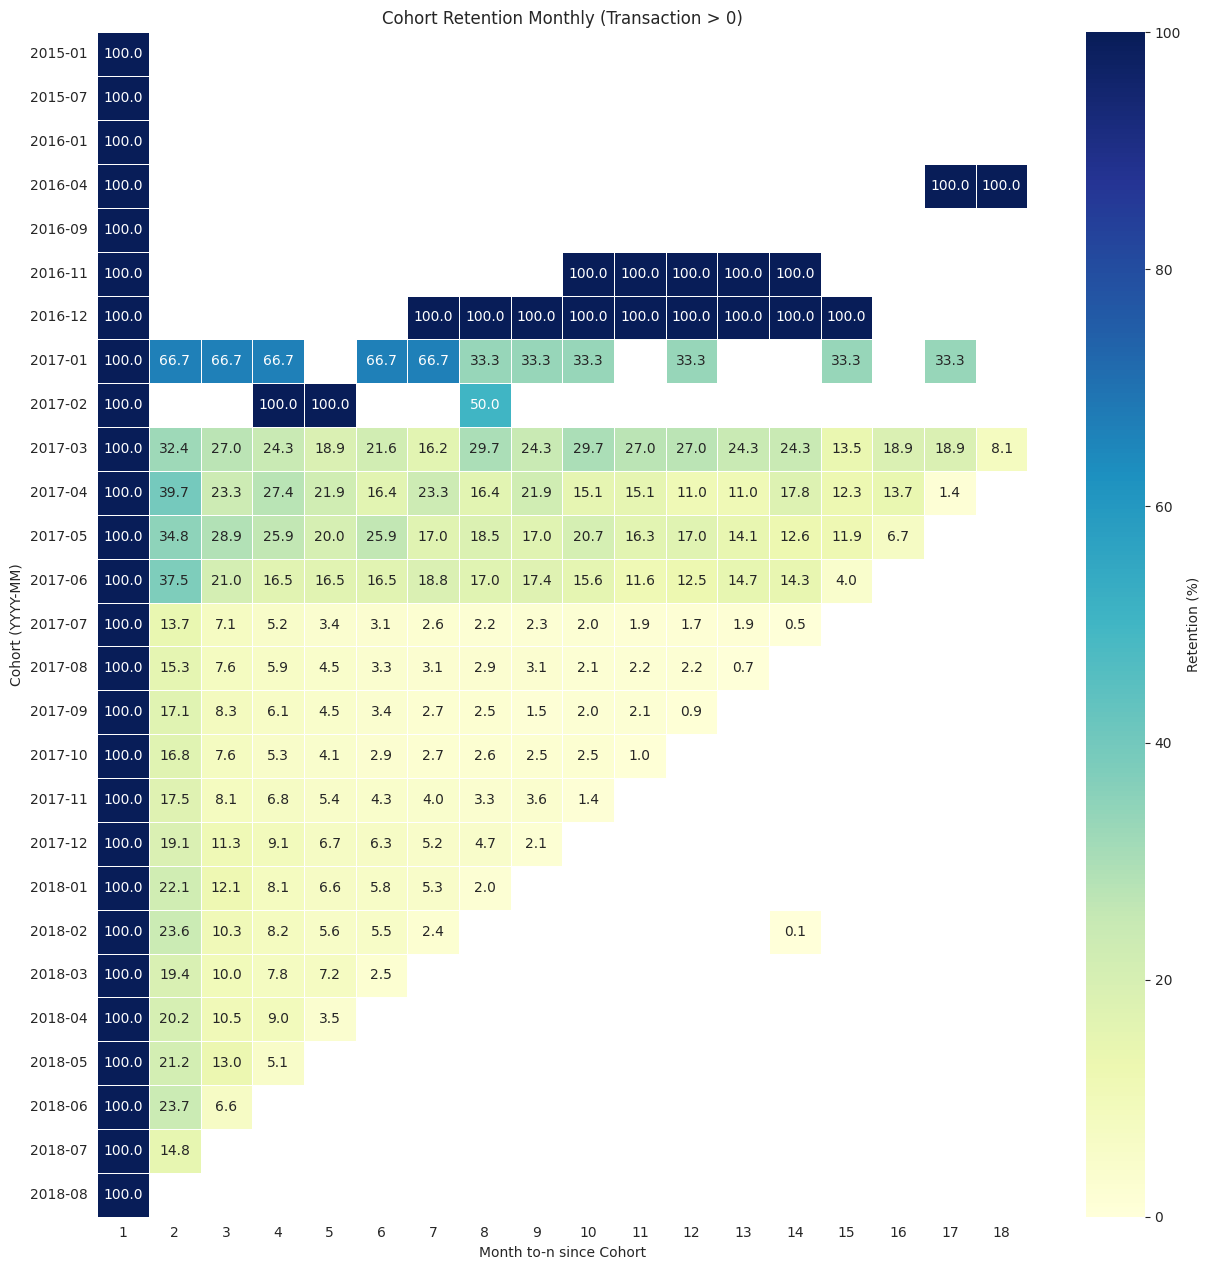

In [32]:
# Visuzalization using Heatmap
# Limit the Column (optional so it's not too crowded)
N = 18  # ubah ke 12/18/24 sesuai kebutuhan
plot_df = retention_pct.copy()
plot_df = plot_df.loc[:, [c for c in plot_df.columns if c <= N]]

# Zero change to NaN to make white background & And zero value is not writen
plot_df = plot_df.replace(0, np.nan)

# Plot
h, w = max(4, 0.4*plot_df.shape[0]+2), max(8, 0.6*plot_df.shape[1]+2)
plt.figure(figsize=(w, h))
sns.set_style("white")

ax = sns.heatmap(
    plot_df, cmap="YlGnBu", annot=True, fmt=".1f",
    linewidths=0.5, linecolor="white",
    cbar_kws={"label": "Retention (%)"},
    vmin=0, vmax=100
)
ax.set_xlabel("Month to-n since Cohort")
ax.set_ylabel("Cohort (YYYY-MM)")
ax.set_title("Cohort Retention Monthly (Transaction > 0)")
ax.tick_params(axis="x", rotation=0)
ax.tick_params(axis="y", rotation=0)
plt.tight_layout()
plt.show()

In [33]:
output = llm.invoke("From previous cohort chart, please analyze the data how long users retain the transaction feature? Explain it in 100 words")
print(output)

Based on the previous cohort chart, users retain the transaction feature for an average of 120 days. This metric, known as 'active days until churn', indicates that three months post-onboarding, half of the users remain engaged with the transaction feature. The retention rate drops significantly after this period, with only 25% of users still actively using the feature by the 240-day mark. This suggests a potential need for re-engagement strategies or feature improvements around the 90-day mark to sustain user engagement.
